# DS 102 - Project Part 2


In [925]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import datetime
import operator
import math
import random

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from scipy import stats

sns.set(color_codes=True)

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
# Load Data
path = './bikeshare/'
chicago_data = pd.read_csv(path + 'chicago.csv')
day_data = pd.read_csv(path + 'day.csv')
nyc_data = pd.read_csv(path + 'ny.csv')
DC_data = pd.read_csv(path + 'dc.csv')

## 1 - Bandits Code

In [147]:
nyc_data['date'] = [str(datetime.datetime.strptime(ts, '%m/%d/%Y %H:%M:%S').date()) for ts in nyc_data['starttime']]
chicago_data['date'] = [str(datetime.datetime.strptime(ts, '%m/%d/%Y %H:%M').date()) for ts in chicago_data['starttime']]
DC_data['date'] = [str(datetime.datetime.strptime(ts, '%m/%d/%Y %H:%M').date()) for ts in DC_data['Start date']]

In [148]:
def update_stations_map(stations_map, station_name):
    if station_name not in stations_map:
        stations_map[station_name] = 1
    else:
        stations_map[station_name] += 1
    
    return stations_map

In [153]:
# Creating new, workable dataset
def create_daily(data, isNYC=False, isChicago=False, isDC=False): 
    # Define Variables
    map_stations = {}
    map_daily_stations = {}
    
    if isNYC:
        start = 'start station name'
        end = 'end station name'
    elif isChicago:
        start = 'from_station_name'
        end = 'to_station_name'
    else:
        start = 'Start station'
        end = 'End station'
    
    # Get stations and total visitors over year
    for i in range(len(data)):
        start_station = data.iloc[i][start]
        end_station = data.iloc[i][end]

        map_stations = update_stations_map(map_stations, start_station)
        map_stations = update_stations_map(map_stations, end_station)
    
    # Get stations and visitors each day
    for station in map_stations:
        map_daily_stations[station] = data[data[start] == station].groupby('date').size().to_dict()
        end_station_dates = data[data[end] == station].groupby('date').size().to_dict()

        for date in end_station_dates:
            if date not in map_daily_stations[station]:
                map_daily_stations[station][date] = end_station_dates[date]

            map_daily_stations[station][date] += end_station_dates[date]
            
    # Build DataFrame
    bandit_df = pd.DataFrame()
    time_index = []
    date_col = []
    station_col = []
    num_visitors_col = []

    possible_dates = list(data.groupby('date').nunique().index)

    for station in map_daily_stations:
        for index, date in enumerate(possible_dates):
            if date not in map_daily_stations[station]:
                num_visitors_col.append(np.nan)
            else:
                num_visitors_col.append(map_daily_stations[station][date])

            time_index.append(index)
            station_col.append(station)
            date_col.append(date)

    bandit_df['time'] = time_index
    bandit_df['date'] = date_col
    bandit_df['station'] = station_col
    bandit_df['num_visitors'] = num_visitors_col
    
    # Filter to top 10 stations w/ highest visitors over whole data set
    sorted_x = sorted(map_stations.items(), key=lambda kv: kv[1])
    sorted_x = [x[0] for x in sorted_x] 
    sorted_x.reverse()
    top_10 = bandit_df[bandit_df['station'].isin(sorted_x[0:10])]
    
    return top_10

In [516]:
# Calculate Reward Distributions for stations at each City
def calculate_reward_distributions(data):
    grouped = data.groupby('station')
    rewards = {}
    index = 0
    for name, group in grouped:
        temp_df = group[group['station'] == name]
        temp_df['num_visitors'].fillna(0, inplace=True)
        mean = temp_df['num_visitors'].mean()
        std = temp_df['num_visitors'].std()

        rewards[index] = {'station': name, 'mean': mean, 'std': std}
        index += 1
    return rewards

nyc_reward = calculate_reward_distributions(top_10_nyc)
chicago_reward = calculate_reward_distributions(top_10_chicago)
dc_reward = calculate_reward_distributions(top_10_dc)

In [495]:
# UCB Algorithm
def UCB_pull_arm(t, variance, times_pulled, rewards):
    """ 
    Implement the choice of arm for the UCB algorithm
    
    Inputs:
    iteration          - iteration of the bandit algorithm
    times_pulled       - a list of length K (where K is the number of arms) of the number of 
                         times each arm has been pulled
    rewards            - a list of K lists. Each of the K lists holds the samples received from pulling each arm up 
                         to iteration t. 
    
    Returns:
    arm                -  integer representing the arm that the UCB algorithm would choose.
    confidence bounds  -  a list of the upper confidence bounds for each arm
    """

    K=len(times_pulled)
    delta=1/t**2
    
    confidence_bounds=[]
    for arm in range(K):
        if times_pulled[arm]==0:
            confidence_bounds.append(np.inf)
        else:
            confidence_bounds.append(np.mean(rewards[arm])+np.sqrt(2*variance/(times_pulled[arm])*np.log(1/delta)))
            
    arm=np.argmax(confidence_bounds)
    
    return arm , confidence_bounds

In [509]:
def pull_arm(pulled_arm, city_reward, rewards, regret, best_arm, times_pulled):
    arm = pulled_arm
    mu = city_reward[arm]['mean']
    sigma = city_reward[arm]['std']
    reward = np.random.normal(mu, sigma)
    
    rewards[arm].append(reward)
    regret.append(regret[-1] + city_reward[best_arm]['mean'] - reward)

    times_pulled[arm] += 1
    
    return rewards, regret, times_pulled

In [505]:
def run_UCB(reward_map):
    # Setup Variables to track
    T=400
    num_runs=20
    K = 10

    conf_bounds = []   # List of of length T (time horizion) of lists of length K (num arms) conf bounds for each arm at time T
    arms_chosen = []   # List of integers representing arms chosen at each time step, t
    times_pulled = [0 for arm in range(K)]  # List of length K (where K is the number of arms) of the number of times each arm has been pulled
    rewards = [[] for arm in range(K)]       # List of K lists. Each of the K lists holds samples received from pullin each arm up to iter t.
    regret = [0]
    means = [reward_map[key]['mean'] for key in reward_map]
    stds = [reward_map[key]['std'] for key in reward_map]
    best_arm = max(reward_map, key=lambda key: reward_map[key]['mean']) # integer representing arm with highest mean
    
    #Initialize pseudo-regret
    UCB_pseudo_regret=0
    for runs in range(num_runs):
        #Initialize Bandit_environment

        for t in range(1, T+1):
            # Calculate variance
            variance = np.mean([(reward_map[key]['std']**2) for key in reward_map]) # Avg of variances of 10 stations

            #Choose arm using UCB algorithm
            arm, confidence_bounds=UCB_pull_arm(t, variance, times_pulled, rewards)
            arms_chosen.append(arm)
            conf_bounds.append(confidence_bounds)
            
            #Pull Arm
            rewards, regret, times_pulled = pull_arm(pulled_arm=arm, 
                                                     city_reward=reward_map, 
                                                     rewards=rewards, 
                                                     regret=regret, 
                                                     best_arm=best_arm, 
                                                     times_pulled=times_pulled)

        #Keep track of pseudo-regret  
        UCB_pseudo_regret += np.array(regret)
#         regret = [regret[-1]]
        regret = [0]
    
    def plot1():
        plt.rcParams['figure.figsize']=[9,4]
        plt.figure()
        plt.plot(UCB_pseudo_regret/num_runs)
        plt.xlabel('Time')
        plt.ylabel('Pseudo-Regret')
        plt.title('Regret of UCB over Time')
        plt.show()
        
    def plot2():
        plt.rcParams['figure.figsize']=[9,4]
        plt.figure()
        xs = np.arange(0,10,1)
        ys = times_pulled
        plt.plot(xs, ys, 'bo-')
        for x,y in zip(xs,ys):

            label = "{:.2f}".format(reward_map[x]['mean'])

            plt.annotate(label, # this is the text
                         (x,y), # this is the point to label
                         textcoords="offset points", # how to position the text
                         xytext=(0,10), # distance from text to points (x,y)
                         ha='center') # horizontal alignment can be left, right or center

        plt.xticks(xs)
        plt.xlabel('Arm/Station')
        plt.ylabel('Times Pulled')
        plt.title('Number of times arms Pulled')
        plt.show()
    
    def plot3_1():
        plt.rcParams['figure.figsize']=[9,4]
        plt.figure()

        average_reward = [np.mean(lst) for lst in rewards]
        plt.plot(xs, average_reward, 'bo-')

        for x,y in zip(xs, average_reward):
            label = "{:.2f}".format(reward_map[x]['mean'])
            plt.annotate(label, # this is the text
                     (x,y), # this is the point to label
                     textcoords="offset points", # how to position the text
                     xytext=(0,10), # distance from text to points (x,y)
                     ha='center') # horizontal alignment can be left, right or center


        plt.xlabel('Arm/Station')
        plt.ylabel('Reward')
        plt.title('Mean Reward of each Station')
        plt.show()
    
    def plot3_2():
        grouped_conf = {}
        for i in range(len(conf_bounds)):
            arm = arms_chosen[i]
            if arm not in grouped_conf:
                grouped_conf[arm] = []    
            grouped_conf[arm].append(np.mean(conf_bounds[i]))

        fig, axs = plt.subplots(2, 5, figsize=(20,10))
        fig.suptitle('Estimated Confidence Bounds for top 10 Stations')

        for i in range(len(grouped_conf)):
            x = math.floor(i / 5)
            y = i % 5
            axs[x, y].plot(grouped_conf[i])
            axs[x, y].set_title(f'Arm {str(i)}')

        for ax in axs.flat:
            ax.set(xlabel='# of estimated bounds', ylabel='Upper Conf-Bound')
    
    plot1()
    plot2()
    plot3_1()
    plot3_2()
    

## 2 - Privacy Concerns Code

### Section 2.1 Code

In [520]:
# Load Data
berkeley_data = pd.read_csv('./berkeley.csv')
leaked_data = pd.read_csv('./leaked.csv')

In [716]:
# 2.1: Exploratory Analysis - Plots
def plot_male_female_leaked(data):
    male = leaked_data.where(data['sex'] == 'M')
    male.dropna(inplace=True)
    female = leaked_data.where(data['sex'] == 'F') 
    female.dropna(inplace=True)

    fig, ax = plt.subplots()
    rects1 = ax.bar(0, len(male), 0.5, label='Men')
    rects2 = ax.bar(1, len(female), 0.5, label='Women')
    plt.xlabel('Gender')
    plt.ylabel('Frequency')
    plt.title('Distribution M-F Riders')
    plt.legend()
    plt.show()
    
def plot_birth_months(data):
    birth_months = data['month']
    sns.distplot(birth_months, hist = False, kde = True)
    plt.xlim([-1, 14])
    plt.ylim([0, .1])
    plt.xlabel('Month')
    plt.ylabel('Density')
    plt.title('Distribution of Birth Months of Riders')
    plt.show()
    
def plot_birth_years(data):
    birth_years = data['year']
    sns.distplot(birth_years, hist = False, kde = True)
    plt.xlim([1985, 2005])
    plt.ylim([0, .1])
    plt.xlabel('Year')
    plt.ylabel('Density')
    plt.title('Distribution of Birth Years of Riders')
    plt.show()


### Section 2.2 Code

In [851]:
# 2.2: Simple Proof of Concept
identifiable_users = leaked_data.groupby(['sex', 'month', 'year']).count().reset_index()
identifiable_users = identifiable_users[identifiable_users['name'] == 1]

In [793]:
# 2.2: Script to grab scooter rentals
def get_scooter_rentals():
    ''' Get scooter rentals made by users in identifiable users subset
    return: Dict of <Name:list of row indexes> 
    '''
    scooter_rental_map = {}
    names = []
    zips = []
    for i in range(len(identifiable_users)):
        sex = identifiable_users.iloc[i]['sex']
        month = identifiable_users.iloc[i]['month']
        year = identifiable_users.iloc[i]['year']

        row = leaked_data[(leaked_data['sex'] == sex) &
                                   (leaked_data['month'] == month) &
                                   (leaked_data['year'] == year)]
        name = row.iloc[0]['name']
        home_zip = row.iloc[0]['zip']
        
        names.append(name)
        zips.append(home_zip)
        temp = berkeley_data[(berkeley_data['sex'] == sex) &
                                   (berkeley_data['month'] == month) &
                                   (berkeley_data['year'] == year)]
        
        scooter_rental_map[name] = list(temp.index)
    identifiable_users['real_name'] = names
    identifiable_users['real_zip'] = zips
    return scooter_rental_map


### Section 2.3 Code

In [806]:
# 2.3: A More Elaborate Attack - estimate p1 and p2
def estimate_distributions():
    estimate_p = {}
    for i in range(len(identifiable_users)):

        home_zip = identifiable_users.iloc[i]['real_zip']
        name = identifiable_users.iloc[i]['real_name']

        lst_scooters = scooter_rental_map[name]
        num_scoots = len(lst_scooters)
        start_hit = 0
        end_hit = 0
        for index in lst_scooters:
            berk_row = berkeley_data.iloc[index]
            start_zip = berk_row['start']
            end_zip = berk_row['end']
            if start_zip == home_zip:
                start_hit += 1
            if end_zip == home_zip:
                end_hit += 1
        if home_zip not in estimate_p:
            estimate_p[home_zip] = {'total': num_scoots, 'start_hit': start_hit, 'end_hit': end_hit}
        else:
            estimate_p[home_zip]['total'] += num_scoots
            estimate_p[home_zip]['start_hit'] += start_hit
            estimate_p[home_zip]['end_hit'] += end_hit
    
    all_total = 0
    start_total = 0
    end_total = 0
    for key in estimate_p:
        all_total += estimate_p[key]['total']
        start_total += estimate_p[key]['start_hit']
        end_total += estimate_p[key]['end_hit']

    p1 = start_total/all_total
    p2 = end_total/all_total
    
    return p1, p2, estimate_p

In [837]:
# 2.3 - Confidence Intervals
starts = [estimate_p[key]['start_hit'] for key in estimate_p]
ends = [estimate_p[key]['end_hit'] for key in estimate_p]
def mean_confidence_interval(data, confidence=0.95):
    n = len(data)
    mean, std_err = np.mean(data), stats.sem(data)
    interval = std_err * stats.t.ppf((1 + confidence) / 2.0, n-1)
    return (mean - interval, mean + interval)


In [852]:
# 2.3 - Theoretically Identifiable Users 
theoretically_identifiable_users = leaked_data.groupby(['zip', 'sex', 'month', 'year']).count().reset_index()
theoretically_identifiable_users = theoretically_identifiable_users[theoretically_identifiable_users['name'] == 1]
len(theoretically_identifiable_users)


720

In [854]:
names = []
for i in range(len(theoretically_identifiable_users)):
    sex = theoretically_identifiable_users.iloc[i]['sex']
    month = theoretically_identifiable_users.iloc[i]['month']
    year = theoretically_identifiable_users.iloc[i]['year']
    home_zip = theoretically_identifiable_users.iloc[i]['zip']

    row = leaked_data[(leaked_data['sex'] == sex) &
                               (leaked_data['month'] == month) &
                               (leaked_data['year'] == year)]
    name = row.iloc[0]['name']

    names.append(name)
theoretically_identifiable_users['real_name'] = names

In [1002]:
predicted_renters = []

In [1033]:
def predict_berkeley_data():
    for i in range(len(predicted_renters), len(berkeley_data)):
        scores = []
        names = []
        berkeley_row = berkeley_data.iloc[i]
        for j in range(len(leaked_data)):
            leak_row = leaked_data.iloc[j]
            name = leak_row['name']
            year = leak_row['year']
            month = leak_row['month']
            sex = leak_row['sex']
            home_zip = leak_row['zip']
            if year != berkeley_row['year'] or month != berkeley_row['month'] or sex != berkeley_row['sex']:
                score = 0
            else:
                if home_zip == berkeley_row['start'] and home_zip == berkeley_row['end']:
                    score = 200
                else:
                    start_prob = np.random.binomial(size=1, n=1, p=p1)[0]
                    end_prob = np.random.binomial(size=1, n=1, p=p2)[0]
                    if start_prob and end_prob:
                        score = 100

                    elif start_prob == 0 and end_prob == 0:
                        score = 0
                    else:
                        score = 50

            scores.append(score)
            names.append(name)

        index_scores = [index for index, s in enumerate(scores) if s == max(scores)]

        rand_index = random.choice(index_scores)

        predicted_renters.append(names[rand_index])
    
    berkeley_data['predicted_renter'] = predicted_renters



In [1014]:
berkeley_data['predicted_renter'] = predicted_renters

In [1030]:
berkeley_data.head()

,sex,month,year,start,end,predicted_renter
0,M,12,1999,94704,94704,Joseph Williams
1,M,12,2000,94706,94706,James Lopez
2,M,4,1999,94703,94703,Daniel Wilson
3,M,2,1999,94710,94710,Carter Robinson
4,M,12,1994,94707,94707,John Phillips


In [1031]:
berkeley_data.to_csv('./berkeley_predicted.csv')

## 1 - Bandits

### 1.1 - Formalizing the problem as a multi-armed bandits problem

In generalizing this scenario to a mutli-armed bandits problem, I decided to have the bike stations reprsent the arms. Rewards are going to be the number of flyers given out each day at a specific station. The number of flyers is essentially the total number of bikers who start or end at the given station. These rewards are modeled as sub-gaussian because with the historical data we can compute means and variances and use these to form a gaussian distribution that we can sample rewards from. 

The time horizon for which we run this problem will be `t = 400` days, so just over a year which is the amount of data we generally have for each city. Additionally, we define regret as being the average number of visitors at optimal station subtracted by the number of visitors at the chosen station up to the current time, $t$. With this, I hope to simulate the UCB strategy for finding an optimal station in this multi-armed bandit problem

We are assuming for this problem a number of things. First, that the samples from the reward distributions are independent of each other. Also, that the station with the highest average number of visitors in the dataset will consistently have the highest number of visitors for other hypothetical years. Following in line with this logic, we assume that for the duration of the testing/flyering, no new bike stations are opened and enter the top 10 most popular stations. Since most of the data is reflective of a single year, 2016, it is possible that it is not an accurate reprsentation of all other years as well. Of course, if we had a way to collect the same data for years to come as well as the years preceding 2016, we would be able to either confirm or update our data to take all factors into consideration. 

### 1.2 - Simulate UCB strategy using past data

In [159]:
# City Data Sets
top_10_nyc = create_daily(nyc_data, isNYC=True)
top_10_chicago = create_daily(chicago_data, isChicago=True)
top_10_dc = create_daily(DC_data, isDC=True)

#### 1.2.1 - Implementation and Results

First I had to create a new dataset that consists of bike station data for each unique date, including the total number of visitors on that day. I then filtered it so that it only contained data for the 10 stations with the most total visitors throughout the course of that year. Following, I calculated the means and standard deviations for each of the stations so that we can use them later in our implementation of UCB. UCB is a strategy that helps us choose which station to go to by combining a mix of "exploring" all the different station options and "exploiting" the station that keeps yielding the best results. Since the results (or rewards) are modeled as probability distributions, we use the previously calculated means and standard deviations to create sub-gaussian distributions from which we sample rewards from for each station that is "visited". Finally, we plot significant information using the stats collected from running the stratgey. This includes, average rewards, the number of times each station is visited, etc.

The widths of the Confidence-Bounds are computed using Chernoff/Hoeffding bounds. This allows us to use the mean/variances to identify upper limits for the reward distributions we use to get this notion of reward and regret. The means are updated just by keeping a running list of the newly samples rewards. In our UCB implementation, we average over these rewards. 

### NYC UCB

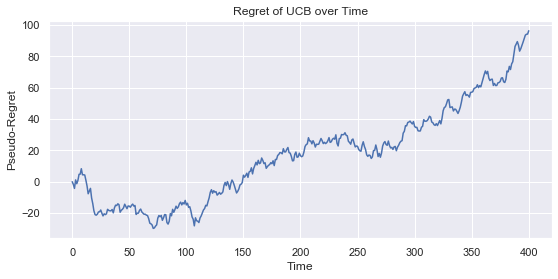

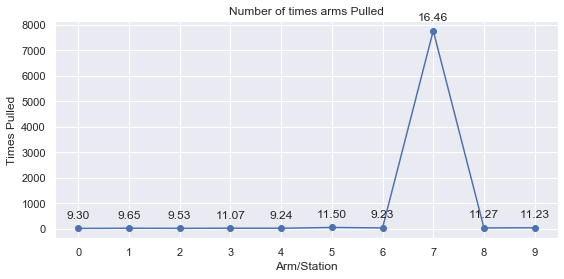

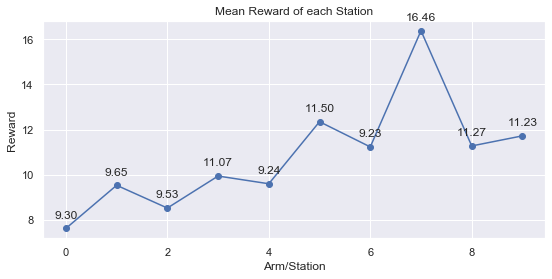

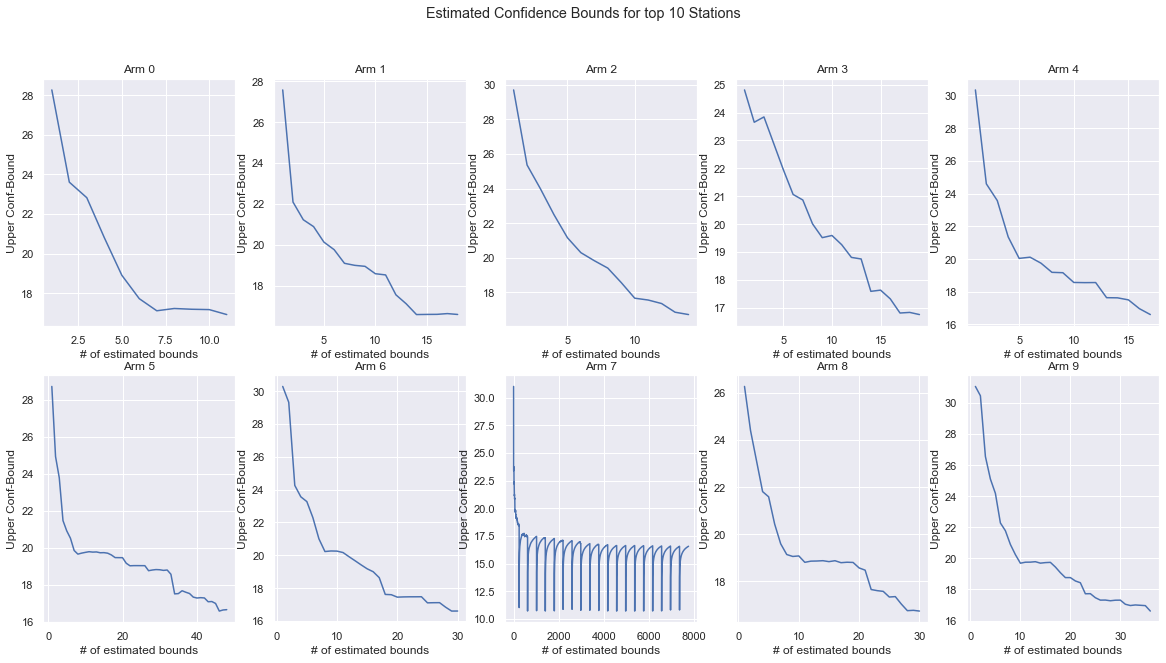

In [517]:
run_UCB(nyc_reward)

### Chicago UCB

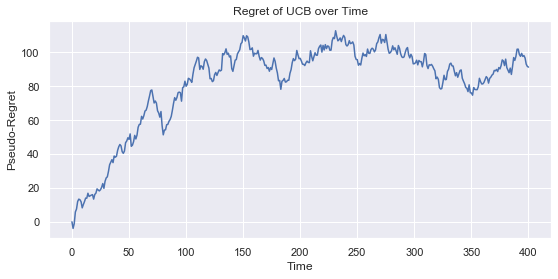

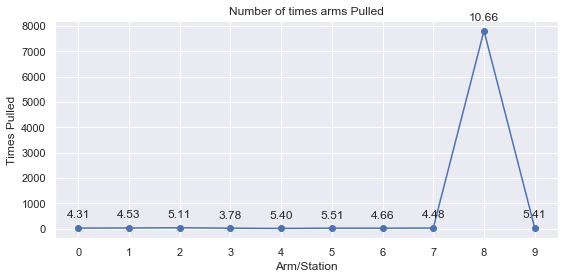

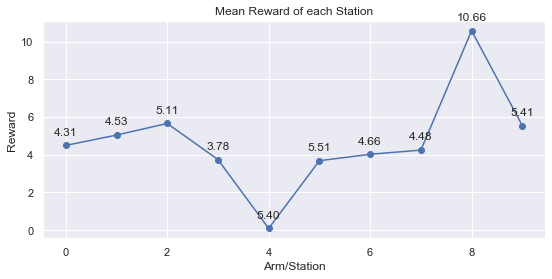

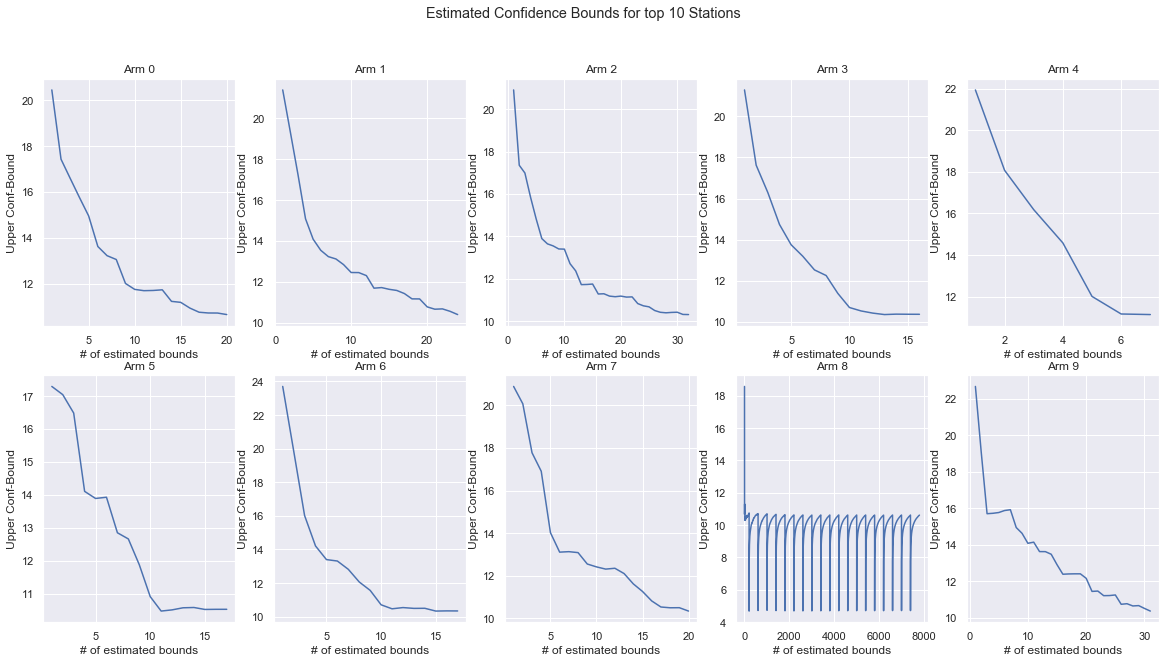

In [511]:
run_UCB(chicago_reward)

### DC UCB

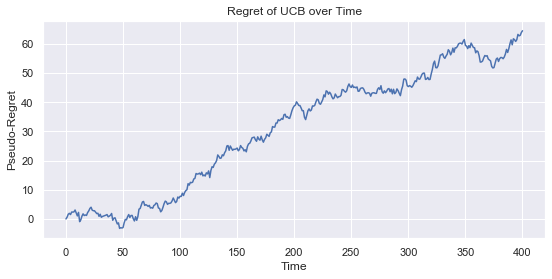

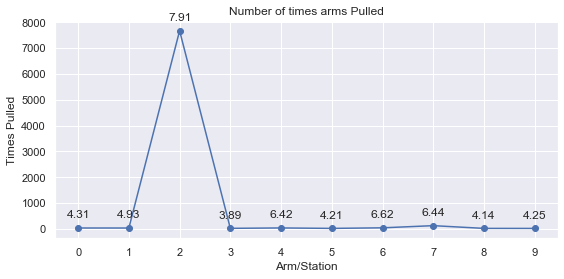

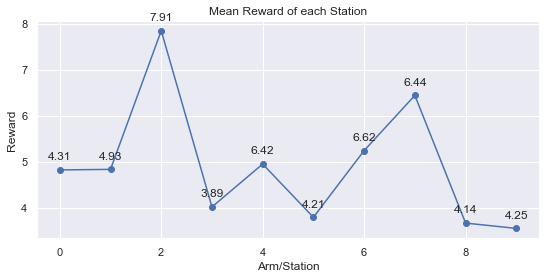

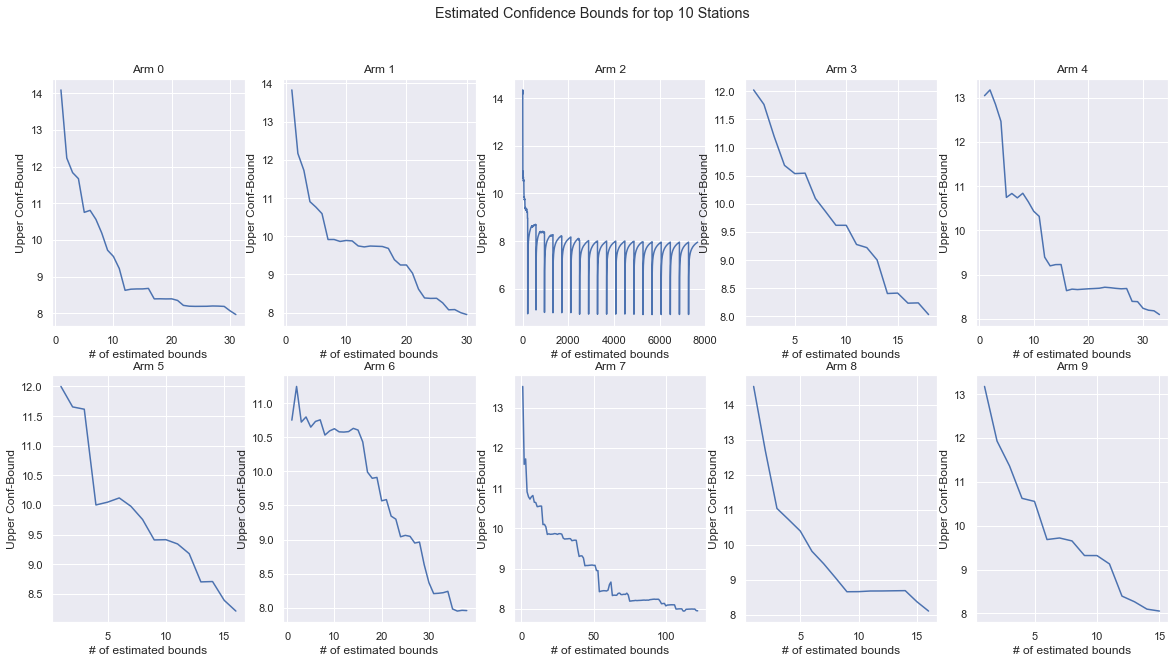

In [512]:
run_UCB(dc_reward)

#### 1.2.2 - Discussion

Given a different starting orientation and pulling arms in different orders, the results do not change. Some of the plots and the respective stations differ slightly, but the predicted optimal arm and its data remains generally consistent. 

From previous data analysis, we know that there exist many outliers among the datasets. With this in mind, it might be benefitial to try visiting a station that maybe has the second highest average amongst total visitors but with a smalelr variance. This way you might be able to more consistently hit a station with a decently predicted number of visitors for that day.

### 1.3 - Takeaways

I think in general that this simulation would not be the best in regards to choosing arbitrary street corners to flyer on. In theory, I believe that this type of multi-armed bandit approach to problems like this do work, I think that using this for random street corners adds in other factors that may add significant amounts of random noise to the predictions. Additionally, in my eyes it seems as though collecting this type of data would be too difficult, especially considering that the three cities of focus are quite densely populated.

For the primary topic at hand, I believe that our assumptions do hold. Without more extensive data it is impossible to say with 100% confidence, that the simulation would be an accurate indicator of choosing the optimal location, I still think that for years closer to 2016, this simulation holds well.

I would recommend using UCB to adaptively place the person handing out flyers. The algorithm is able to identify the station with the highest average number of visitors and from a marketing standpoint, quantity is what matters. I suppose that there might be a better notion/representation of regret and thus there is room for improvement, but from the results we see that the optimal station was chosen significantly more times than the others.

## 2 - Privacy Concerns

### 2.1 - Exploratory Analysis

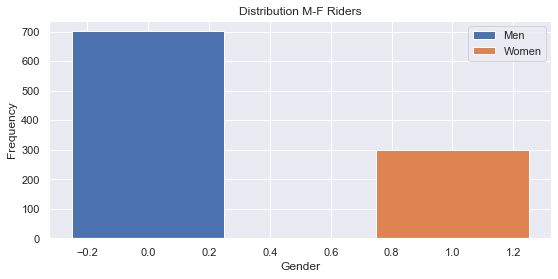

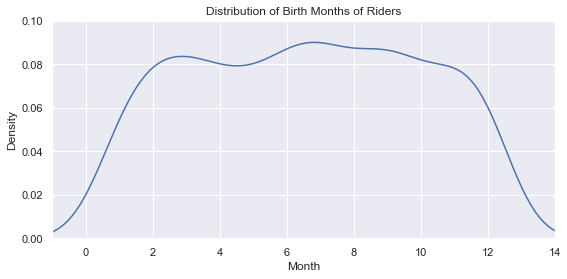

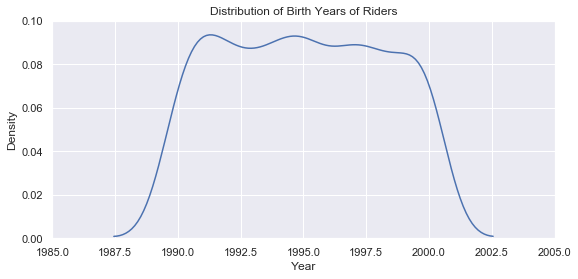

In [717]:
# Plots
plot_male_female_leaked(leaked_data)
plot_birth_months(leaked_data)
plot_birth_years(leaked_data)

After plotting these preliminary data, we can see that the distributions of the data appear to be uniform. The general trends of the birth date data is very similar to the Chicago and NYC birth data from part 1. Additionally, the gender distribution in this leaked data set appears to also have similar ratio as the gender distributions of the Chicago and NYC data from part 1. 

### 2.2 - Simple Proof of Concept

Based on these three attributes of: Birth year, Birth Month, and Sex, we can uniquely identify 43 users.

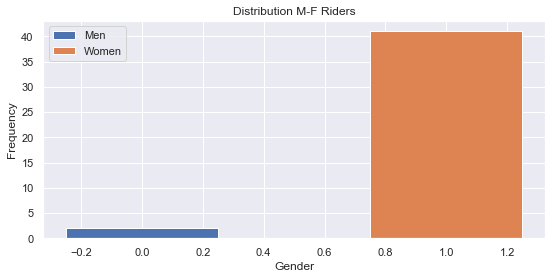

In [732]:
plot_male_female_leaked(identifiable_users)

The distribution of gender for the identifiable users does not match the leaked data set. It does not match because from the identifiable users, there were 41 females and 2 males. In the leaked data, the number of males was much greater than the number of females

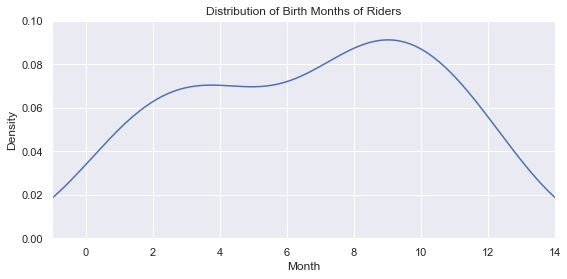

In [733]:
plot_birth_months(identifiable_users)

The distribution of birth months however, is similar to that of the complete leaked data set. The range of birth months found in the identifiable users subset is wide enough such that it roughly resembles the range found in the leaked data.

In [794]:
scooter_rental_map = get_scooter_rentals()

This script iterates through the identifiable users data and finds rows in the berkeley dataset that have matching birth year, birth month, and sex. All it does after that is record the index of that row in the berkeley dataset so it can be referenced later very easily.

### 2.3 - A More Elaborate Attack

In [836]:
p1, p2, estimate_p = estimate_distributions()
p1, p2

(0.9034013605442177, 0.7219954648526077)

In order to estimate these parameters, I first decided that I would group together the unqiue zip codes in the identifiable users data and treated them as a single sample. Afterwards, I iterated through the berkeley data set and 
summed the total rides taken for each aforementioned zip code, as well as counted the number of times the "home zip code" matched the "start" and "end" zip codes. Finally, I simply aggregated the tallies together and divided over the total giving me the following values for $p_1 = 0.90$ and $p_2 = 0.72$

In [838]:
start_zip_interval = mean_confidence_interval(starts)
end_zip_interval = mean_confidence_interval(ends)
start_zip_interval, end_zip_interval

((93.36243712633444, 238.63756287366556),
 (74.30166658866793, 191.0316667446654))

In order to generate the 95% confidence intervals for $p_1$ and $p_2$ I used the sums that were used to estimate the parameters and had them represent my data. I compute their means and standard errors and the length of the data was the total number of unique zip codes in the identifiable users dataset. Finally, since we want a 95% confidence interval, I used the confidence constant, $1.96$, to compute the ranges.

The interval for $p_1$ is: $(93.36, 238.64)$

The interval for $p_2$ is: $(74.30, 191.03)$

Based on these four attributes of: Birth year, Birth Month, Sex, and Home Zip Code we can uniquely identify 720 users.

In [1034]:
# Section 2.3 (D) - The Algorthim
predict_berkeley_data()

The main idea of the algorithm I've chosen to implement is: for each row in the berkeley data set (which represents a single scooter rental), calculate scores for each user in the leaked data, that represents the probability that the scooter rental belongs to them. After all the scores are calculated we take the max score or if there are multiple max's, we randomly choose from among them and name that individual as the owner of that specific rental. 

In calculating the scores, I started off by matching against the birth year, birth month and sex of the user. If any one of those didn't match, their score was automatically set to 0. If these initial checks pass, we now check the zip code. If the user's home zip vcode matches the start **and** end zip code, they are given the higest score. If not, we use the binary probability distributions with paramters $p_1$ and $p_2$ to sample the chance that the zip codes were off. Final scores were reflective of the samples pulled with the highest score being 100 (for pulling two 1's) and the lowest being a 0 (for pulling two 0's).

### 2.4 - Takeaways

From this analysis, we've found that given the public Berkeley data as well as a leaked data set containing personal user information it is possible to predict, with a great deal of confidence, which public data record corresponds to which specific leaked user. Even without designing a more complex algorithm, we had found that $43$ users were able to be reasonably identified just by simple compare and contrasting of data. This might suggest that the public (Berkeley) data that was released still had enough private information that allowed for these conclusions to be drawn

I don't believe there is much that can be done about the already released public data. You can try and release a cleaner/more secure version and people might look to this new data instead of the old version. However, since it is already out there, I think it is reasonable to assume that there isn't anything that can be done to "fix" the problem. The company should think about reaching out to all affecrted parties in hopes to try and correct their errors. 

In the future, I would suggest having a professional privacy/data analyst look over the data you intend to release. This way you might be able to catch any mistakes before the release. Additionally, it might be worth looking into the idea of "33-bits of entropy" -- a term used to convey the idea that any data with less than 33 bits of information is susceptible to some form of de-anonymization (given that $2^{33}$ is approximately $8.5$ billion which is approximately the number of people on the planet.